In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Cargar el dataset
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv("/content/drive/My Drive/MODELOS MONOGRAFIA/otrasinfeccionesMonografia.csv", sep=";")

# Mostrar las primeras filas del dataset para analizar su estructura
data.head()

Mounted at /content/drive


,fecha,semana,tipo,varones,mujeres,total
0,7/1/2019,1,EDA,486,527,1013
1,7/1/2019,1,IRAsinNeumo,1176,1292,2468
2,7/1/2019,1,neumonia,30,36,66
3,14/1/2019,2,EDA,585,627,1212
4,14/1/2019,2,IRAsinNeumo,1789,1963,3752


In [ ]:
# Filtrar los datos para Neumonía en mujeres y preparar el formato
data_neumonia_mujeres = data[data['tipo'] == 'neumonia'][['fecha', 'mujeres']]
data_neumonia_mujeres['fecha'] = pd.to_datetime(data_neumonia_mujeres['fecha'], dayfirst=True)
data_neumonia_mujeres = data_neumonia_mujeres.sort_values(by='fecha')
data_neumonia_mujeres.set_index('fecha', inplace=True)

# Prueba de Dickey-Fuller para verificar estacionaridad
result_neumonia_mujeres = adfuller(data_neumonia_mujeres['mujeres'])
print('Prueba de Dickey-Fuller para Neumonía - Mujeres:')
print(f'Estadístico de prueba: {result_neumonia_mujeres[0]:.4f}')
print(f'P-valor: {result_neumonia_mujeres[1]:.4f}')
for key, value in result_neumonia_mujeres[4].items():
    print(f'Valor Crítico {key}: {value:.4f}')

Prueba de Dickey-Fuller para Neumonía - Mujeres:
Estadístico de prueba: -4.1043
P-valor: 0.0010
Valor Crítico 1%: -3.4529
Valor Crítico 5%: -2.8715
Valor Crítico 10%: -2.5721


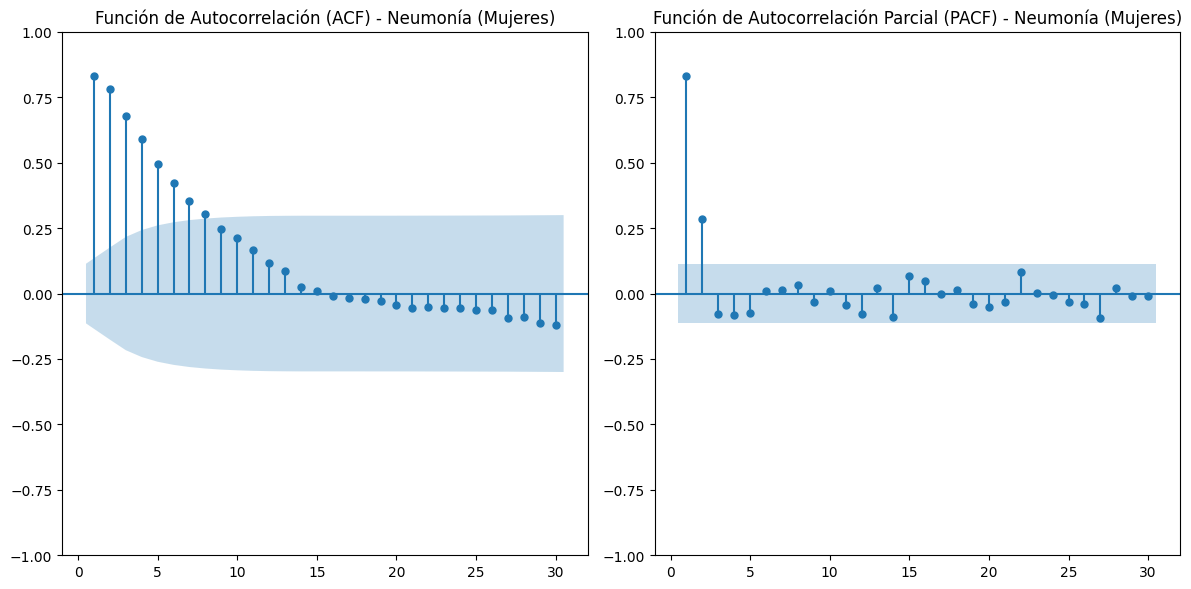

In [ ]:
# Graficar ACF y PACF de la serie de Neumonía en mujeres
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_acf(data_neumonia_mujeres['mujeres'], lags=30, zero=False, ax=plt.gca())
plt.title("Función de Autocorrelación (ACF) - Neumonía (Mujeres)")

plt.subplot(1, 2, 2)
plot_pacf(data_neumonia_mujeres['mujeres'], lags=30, zero=False, ax=plt.gca())
plt.title("Función de Autocorrelación Parcial (PACF) - Neumonía (Mujeres)")

plt.tight_layout()
plt.show()

# ARIMA

In [ ]:
# Configurar y ajustar el modelo ARIMA
model_arima_neumonia_mujeres = ARIMA(data_neumonia_mujeres, order=(1, 0, 1))
arima_result_neumonia_mujeres = model_arima_neumonia_mujeres.fit()

# Mostrar el resumen del modelo
print(arima_result_neumonia_mujeres.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                mujeres   No. Observations:                  296
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1264.863
Date:                Tue, 03 Dec 2024   AIC                           2537.727
Time:                        15:25:53   BIC                           2552.488
Sample:                    01-07-2019   HQIC                          2543.637
                         - 09-02-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         61.4959     10.259      5.995      0.000      41.389      81.603
ar.L1          0.9066      0.028     32.544      0.000       0.852       0.961
ma.L1         -0.2494      0.051     -4.919      0.0

In [ ]:
# Dividir en entrenamiento y prueba (85% entrenamiento, 15% prueba)
train_size = int(len(data_neumonia_mujeres) * 0.85)
train_neumonia_mujeres = data_neumonia_mujeres[:train_size]
test_neumonia_mujeres = data_neumonia_mujeres[train_size:]

# Realizar predicciones en el conjunto de prueba
predictions_arima_neumonia_mujeres = arima_result_neumonia_mujeres.predict(start=len(train_neumonia_mujeres), end=len(data_neumonia_mujeres)-1, typ='levels')

# Calcular métricas de evaluación
y_true = test_neumonia_mujeres['mujeres'].values
y_pred = predictions_arima_neumonia_mujeres.values

mae_arima = mean_absolute_error(y_true, y_pred)
rmse_arima = np.sqrt(mean_squared_error(y_true, y_pred))
mape_arima = mean_absolute_percentage_error(y_true, y_pred) * 100  # Convertir a porcentaje
smape_arima = 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

# Imprimir métricas de evaluación
print(f'MAE: {mae_arima:.2f}')
print(f'RMSE: {rmse_arima:.2f}')
print(f'MAPE: {mape_arima:.2f}%')
print(f'sMAPE: {smape_arima:.2f}%')

MAE: 14.53
RMSE: 18.63
MAPE: 21.31%
sMAPE: 20.23%


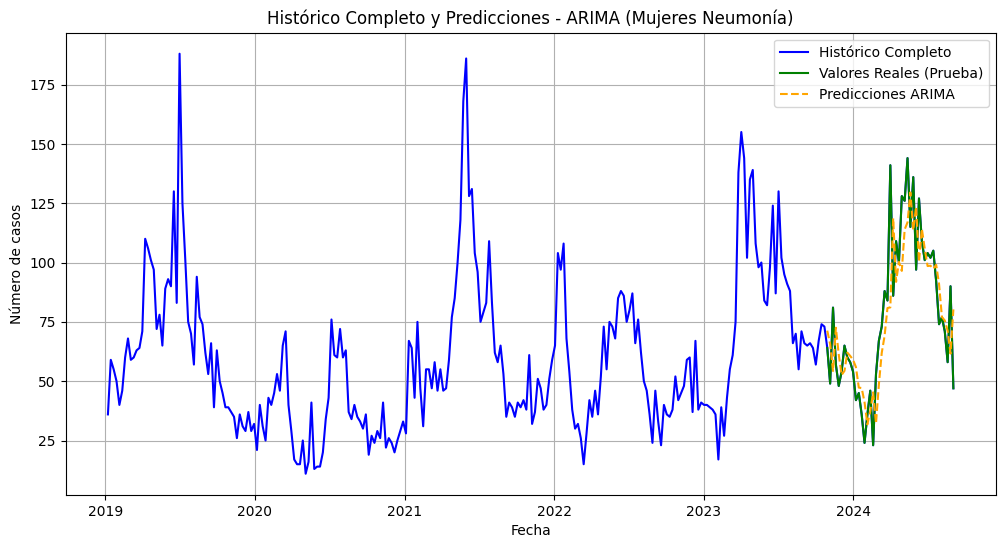

In [ ]:
# Graficar el histórico y las predicciones del modelo ARIMA

plt.figure(figsize=(12, 6))
plt.plot(data_neumonia_mujeres.index, data_neumonia_mujeres['mujeres'], label="Histórico Completo", color="blue")
plt.plot(test_neumonia_mujeres.index, y_true, label="Valores Reales (Prueba)", color="green")
plt.plot(test_neumonia_mujeres.index, y_pred, color='orange', linestyle='--', label="Predicciones ARIMA")
plt.title("Histórico Completo y Predicciones - ARIMA (Mujeres Neumonía)")
plt.xlabel("Fecha")
plt.ylabel("Número de casos")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Crear DataFrame comparativo de los valores reales y predichos para ARIMA
comparison_df_arima_neumonia_mujeres = pd.DataFrame({
    'Fecha': test_neumonia_mujeres.index,
    'Valores Reales': y_true,
    'Predicciones ARIMA': y_pred
})

# Mostrar el DataFrame comparativo
print(comparison_df_arima_neumonia_mujeres)

        Fecha  Valores Reales  Predicciones ARIMA
0  2023-10-30              64           71.294569
1  2023-11-06              49           65.585565
2  2023-11-13              81           54.304396
3  2023-11-20              57           72.519102
4  2023-11-27              48           61.290997
5  2023-12-04              54           52.576046
6  2023-12-11              65           54.345114
7  2023-12-18              60           62.014959
8  2023-12-25              58           60.642351
9  2024-01-01              54           58.985690
10 2024-01-08              42           55.943889
11 2024-01-15              45           47.299440
12 2024-01-22              36           47.114662
13 2024-01-29              24           41.154279
14 2024-02-05              36           31.781839
15 2024-02-12              46           37.329770
16 2024-02-19              23           45.285043
17 2024-02-26              53           32.155043
18 2024-03-04              67           48.594303


In [ ]:
# prompt: realiza 8 predicciones futuras con el modelo ARIMA, los 8 datos reales son:
#  72
# 58
# 56
# 56
# 50
# 59
# 52
# 48

# Realizar predicciones futuras
future_steps = 8
future_predictions = (arima_result_neumonia_mujeres.forecast(steps=future_steps)).round()

# Imprimir las predicciones
future_predictions

,predicted_mean
2024-09-09,57.0
2024-09-16,57.0
2024-09-23,58.0
2024-09-30,58.0
2024-10-07,58.0
2024-10-14,59.0
2024-10-21,59.0
2024-10-28,59.0


In [ ]:
# prompt: estos son los 8 datos reales futuros, realiza la comparacion con la prediccion y evalualo:
#  72
# 58
# 56
# 56
# 50
# 59
# 52
# 48

# Assuming 'future_predictions' contains the predicted values and you have the actual values in a list called 'actual_values'

actual_values = [40, 55, 49, 47, 49, 60, 41, 42]

# Evaluate the predictions
mae = mean_absolute_error(actual_values, future_predictions)
rmse = np.sqrt(mean_squared_error(actual_values, future_predictions))
mape = mean_absolute_percentage_error(actual_values, future_predictions) * 100
smape = 100 * np.mean(2 * np.abs(actual_values - future_predictions) / (np.abs(actual_values) + np.abs(future_predictions)))

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')
print(f'sMAPE: {smape:.2f}%')

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Fecha': range(1, len(actual_values) + 1),  # Replace with actual dates if available
    'Valores Reales': actual_values,
    'Predicciones': future_predictions
})

comparison_df

MAE: 10.50
RMSE: 12.20
MAPE: 24.04%
sMAPE: 20.57%


,Fecha,Valores Reales,Predicciones
2024-09-09,1,40,57.0
2024-09-16,2,55,57.0
2024-09-23,3,49,58.0
2024-09-30,4,47,58.0
2024-10-07,5,49,58.0
2024-10-14,6,60,59.0
2024-10-21,7,41,59.0
2024-10-28,8,42,59.0


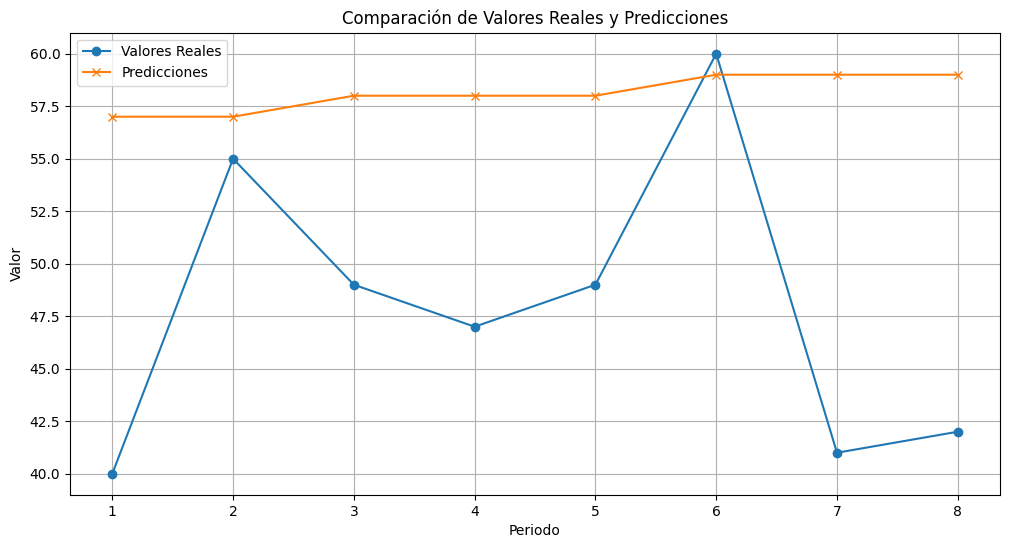

In [ ]:
# prompt: grafica la comparación de actual_values y future_predictions

import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(actual_values) + 1), actual_values, label='Valores Reales', marker='o')
plt.plot(range(1, len(future_predictions) + 1), future_predictions, label='Predicciones', marker='x')
plt.xlabel('Periodo')
plt.ylabel('Valor')
plt.title('Comparación de Valores Reales y Predicciones')
plt.legend()
plt.grid(True)
plt.show()

# SARIMA

In [ ]:
# Configurar y ajustar el modelo SARIMA
model_sarima_neumonia_mujeres = SARIMAX(data_neumonia_mujeres,
                                        order=(1, 0, 1),
                                        seasonal_order=(1, 0, 1, 52),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
sarima_result_neumonia_mujeres = model_sarima_neumonia_mujeres.fit()

# Mostrar el resumen del modelo
print(sarima_result_neumonia_mujeres.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                            mujeres   No. Observations:                  296
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 52)   Log Likelihood               -1024.463
Date:                            Tue, 03 Dec 2024   AIC                           2058.926
Time:                                    15:25:59   BIC                           2076.371
Sample:                                01-07-2019   HQIC                          2065.953
                                     - 09-02-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9807      0.012     79.303      0.000       0.956       1.005
ma.L1         -0.2539      0.054   

In [ ]:
# Realizar predicciones en el conjunto de prueba
predictions_sarima_neumonia_mujeres = sarima_result_neumonia_mujeres.predict(start=len(train_neumonia_mujeres), end=len(data_neumonia_mujeres)-1, typ='levels')

# Calcular métricas de evaluación
y_true_sarima = test_neumonia_mujeres['mujeres'].values
y_pred_sarima = predictions_sarima_neumonia_mujeres.values

mae_sarima = mean_absolute_error(y_true_sarima, y_pred_sarima)
rmse_sarima = np.sqrt(mean_squared_error(y_true_sarima, y_pred_sarima))
mape_sarima = mean_absolute_percentage_error(y_true_sarima, y_pred_sarima) * 100  # Convertir a porcentaje
smape_sarima = 100 * np.mean(2 * np.abs(y_true_sarima - y_pred_sarima) / (np.abs(y_true_sarima) + np.abs(y_pred_sarima)))

# Imprimir métricas de evaluación
print(f'MAE: {mae_sarima:.2f}')
print(f'RMSE: {rmse_sarima:.2f}')
print(f'MAPE: {mape_sarima:.2f}%')
print(f'sMAPE: {smape_sarima:.2f}%')

MAE: 14.79
RMSE: 18.36
MAPE: 21.25%
sMAPE: 20.62%


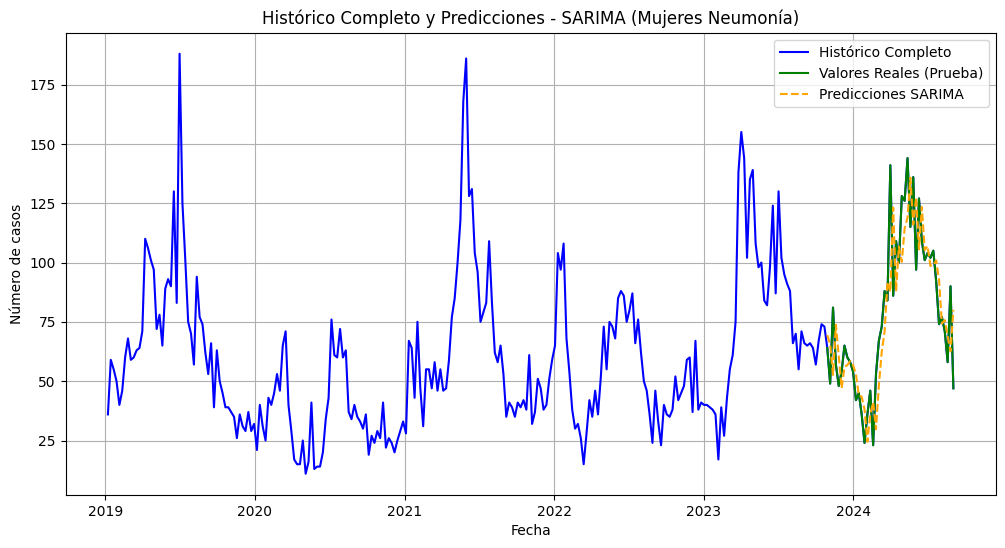

In [ ]:
# Graficar el histórico completo junto con las predicciones del modelo SARIMA
plt.figure(figsize=(12, 6))
plt.plot(data_neumonia_mujeres.index, data_neumonia_mujeres['mujeres'], label="Histórico Completo", color="blue")
plt.plot(test_neumonia_mujeres.index, y_true_sarima, label="Valores Reales (Prueba)", color="green")
plt.plot(test_neumonia_mujeres.index, y_pred_sarima, color='orange', linestyle='--', label="Predicciones SARIMA")
plt.title("Histórico Completo y Predicciones - SARIMA (Mujeres Neumonía)")
plt.xlabel("Fecha")
plt.ylabel("Número de casos")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Crear DataFrame comparativo de los valores reales y predichos para SARIMA
comparison_df_sarima_neumonia_mujeres = pd.DataFrame({
    'Fecha': test_neumonia_mujeres.index,
    'Valores Reales': y_true_sarima,
    'Predicciones SARIMA': y_pred_sarima
})

# Mostrar el DataFrame comparativo
print(comparison_df_sarima_neumonia_mujeres)

        Fecha  Valores Reales  Predicciones SARIMA
0  2023-10-30              64            69.399995
1  2023-11-06              49            65.518003
2  2023-11-13              81            52.642649
3  2023-11-20              57            73.764852
4  2023-11-27              48            60.567566
5  2023-12-04              54            47.007267
6  2023-12-11              65            55.990433
7  2023-12-18              60            56.796683
8  2023-12-25              58            58.408644
9  2024-01-01              54            56.752026
10 2024-01-08              42            52.906206
11 2024-01-15              45            44.050487
12 2024-01-22              36            43.443003
13 2024-01-29              24            38.095554
14 2024-02-05              36            24.439767
15 2024-02-12              46            36.217993
16 2024-02-19              23            41.136088
17 2024-02-26              53            29.714837
18 2024-03-04              67  

# Predicciones a futuro

            Predicciones SARIMA
2024-09-09                 55.0
2024-09-16                 54.0
2024-09-23                 53.0
2024-09-30                 51.0
2024-10-07                 52.0
2024-10-14                 52.0
2024-10-21                 51.0
2024-10-28                 49.0


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


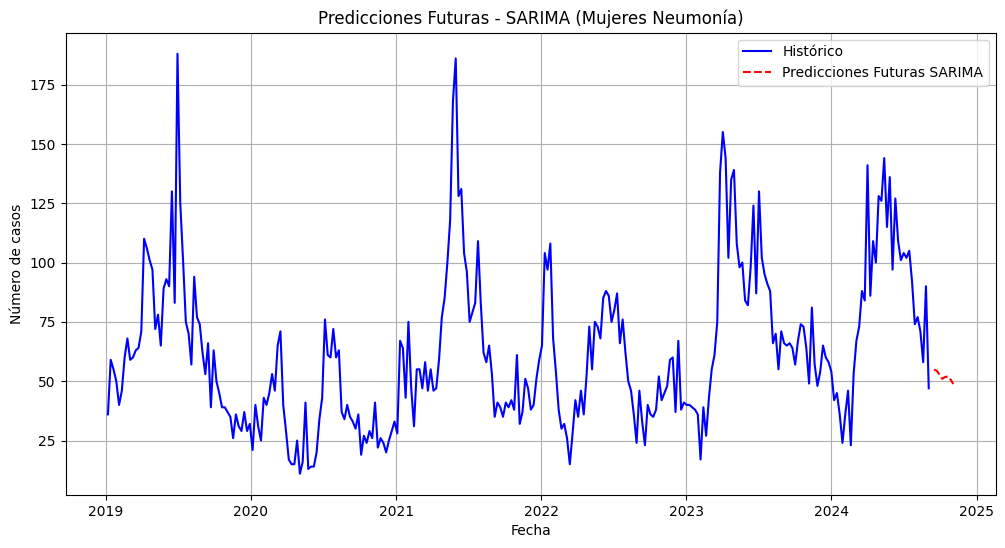

In [ ]:
# prompt: realiza predicciones a futuro para los proximas 8 fechas

# Predicciones a futuro con SARIMA (8 fechas)
future_steps = 8
future_dates = pd.date_range(start=data_neumonia_mujeres.index[-1], periods=future_steps + 1, freq='W')[1:]
future_predictions_sarima = sarima_result_neumonia_mujeres.predict(start=len(data_neumonia_mujeres), end=len(data_neumonia_mujeres) + future_steps - 1, typ='levels')

# Crear DataFrame para las predicciones futuras
future_predictions_df = pd.DataFrame({
    #'Fecha': future_dates,
    'Predicciones SARIMA': future_predictions_sarima.round()
})

# Mostrar el DataFrame de predicciones futuras
print(future_predictions_df)

# Graficar las predicciones futuras
plt.figure(figsize=(12, 6))
plt.plot(data_neumonia_mujeres.index, data_neumonia_mujeres['mujeres'], label="Histórico", color="blue")
plt.plot(future_dates, future_predictions_sarima, color='red', linestyle='--', label="Predicciones Futuras SARIMA")
plt.title("Predicciones Futuras - SARIMA (Mujeres Neumonía)")
plt.xlabel("Fecha")
plt.ylabel("Número de casos")
plt.legend()
plt.grid(True)
plt.show()

SARIMA Future MAE: 6.31
SARIMA Future RMSE: 7.61
SARIMA Future MAPE: 14.15%
SARIMA Future sMAPE: 12.98%
                Fecha  Valores Reales  Predicciones SARIMA
2024-09-09 2024-09-15              40                 55.0
2024-09-16 2024-09-22              55                 54.0
2024-09-23 2024-09-29              49                 53.0
2024-09-30 2024-10-06              47                 51.0
2024-10-07 2024-10-13              49                 52.0
2024-10-14 2024-10-20              60                 52.0
2024-10-21 2024-10-27              41                 51.0
2024-10-28 2024-11-03              42                 49.0


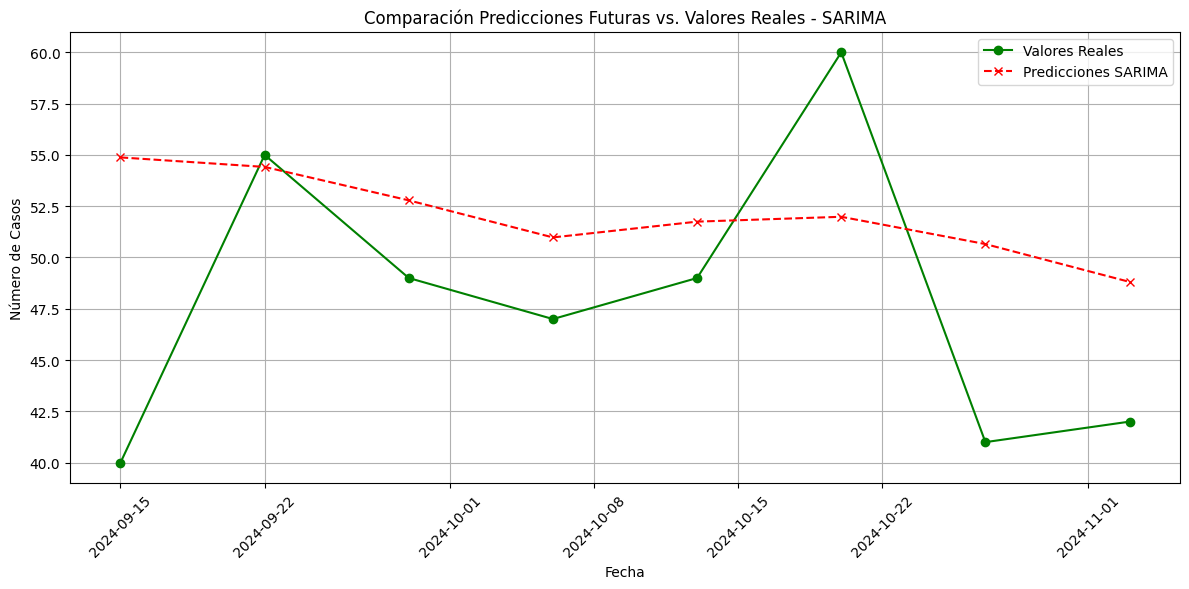

In [ ]:
# prompt: estos son los 8 datos reales futuros, realiza la comparación con la predicción sarima, graficalo y evalualo:


# Assuming 'future_predictions_sarima' contains the SARIMA predictions and 'future_dates' the corresponding dates
# and 'actual_values' are the real future values


actual_values = [40, 55, 49, 47, 49, 60, 41, 42]

# Evaluate the SARIMA predictions
mae_sarima_future = mean_absolute_error(actual_values, future_predictions_sarima)
rmse_sarima_future = np.sqrt(mean_squared_error(actual_values, future_predictions_sarima))
mape_sarima_future = mean_absolute_percentage_error(actual_values, future_predictions_sarima) * 100
smape_sarima_future = 100 * np.mean(2 * np.abs(actual_values - future_predictions_sarima) / (np.abs(actual_values) + np.abs(future_predictions_sarima)))

print(f'SARIMA Future MAE: {mae_sarima_future:.2f}')
print(f'SARIMA Future RMSE: {rmse_sarima_future:.2f}')
print(f'SARIMA Future MAPE: {mape_sarima_future:.2f}%')
print(f'SARIMA Future sMAPE: {smape_sarima_future:.2f}%')


# Create a comparison DataFrame for future predictions
comparison_df_future = pd.DataFrame({
    'Fecha': future_dates,
    'Valores Reales': actual_values,
    'Predicciones SARIMA': future_predictions_sarima.round()
})

print(comparison_df_future)

# Plot the future predictions against actual values
plt.figure(figsize=(12, 6))
plt.plot(future_dates, actual_values, label="Valores Reales", marker='o', linestyle='-', color='green')
plt.plot(future_dates, future_predictions_sarima, label="Predicciones SARIMA", marker='x', linestyle='--', color='red')
plt.title("Comparación Predicciones Futuras vs. Valores Reales - SARIMA")
plt.xlabel("Fecha")
plt.ylabel("Número de Casos")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout() # Ajusta el espaciado para evitar que las etiquetas se superpongan
plt.show()